In [50]:
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [51]:
gasn = pd.read_csv('data_materias_eur/GAS-EUR.csv')

In [52]:
gasn = gasn.drop(columns=['Open','High', 'Low', 'Adj Close', 'Volume' ])  #eliminamos columnas innecesarias

gasn['Date'] = pd.to_datetime(gasn['Date'])  #convertimos a fecha

In [53]:
gasn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976 entries, 0 to 1975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1976 non-null   datetime64[ns]
 1   Close   1976 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


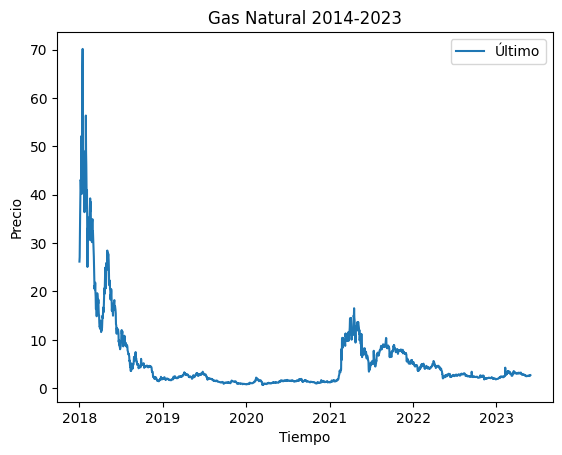

In [54]:
sns.lineplot(x=gasn.Date,y=gasn['Close'], data=gasn['Close'])

plt.title('Gas Natural 2014-2023')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

plt.show()

Filtro desde 2019

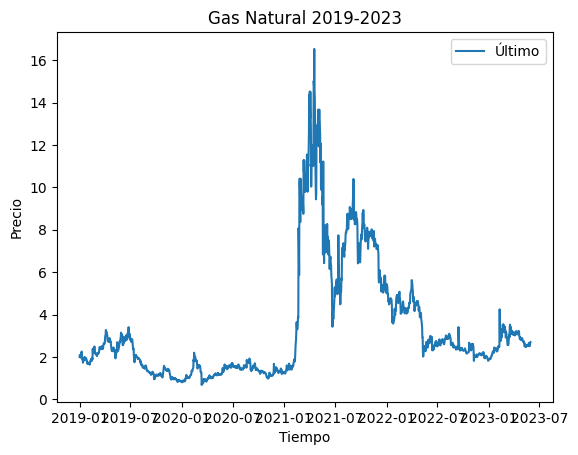

In [55]:
# Filtrar los datos desde el año 2019
gasn_filtered = gasn.loc[gasn['Date'].dt.year >= 2019]

# Graficar el precio 'Close' filtrado
sns.lineplot(x='Date', y='Close', data=gasn_filtered)

plt.title('Gas Natural 2019-2023')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

plt.show()

Desde el año 2021

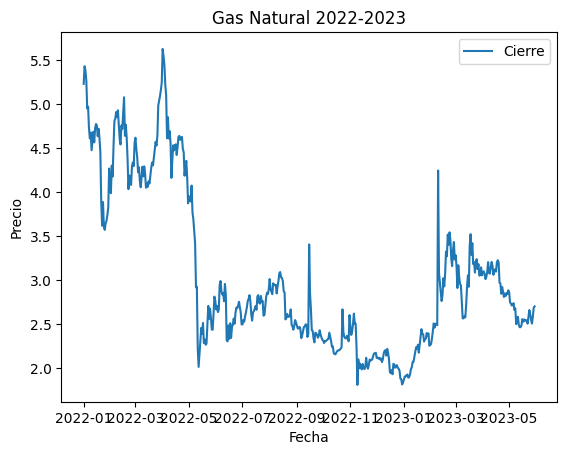

In [56]:
# Filtrar los datos desde el año 2019
gasn_filtered = gasn.loc[gasn['Date'].dt.year >= 2022]

# Graficar el precio 'Close' filtrado
sns.lineplot(x='Date', y='Close', data=gasn_filtered)

plt.title('Gas Natural 2022-2023')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(['Cierre'])

plt.show()

<AxesSubplot: >

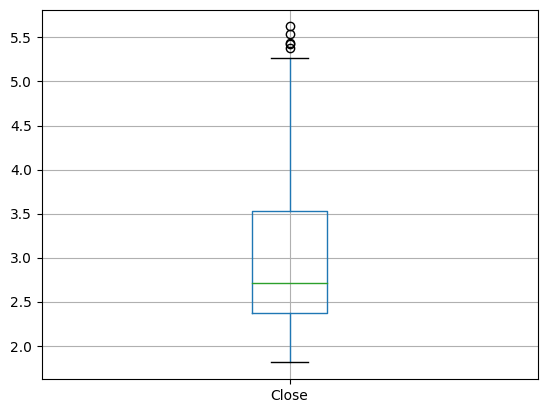

In [57]:
gasn_filtered.boxplot()

Relleno los fines de semana

In [58]:
import datetime

In [59]:
gasn = gasn.set_index('Date')
date_range = pd.date_range(start=gasn.index.min(), end=gasn.index.max())
filled_gasn = pd.merge(pd.DataFrame(date_range, columns=['Date']), gasn, how='left', left_on='Date', right_index=True)

filled_gasn = filled_gasn.fillna(method='ffill')



In [60]:
filled_gasn.head()

,Date,Close
0,2018-01-01,26.183029
1,2018-01-02,27.124121
2,2018-01-03,32.633389
3,2018-01-04,35.773663
4,2018-01-05,39.078068


Plotiando

Divido en train y test

In [61]:
#poner el limite de división

fecha = pd.to_datetime('2023-05-24')
index = filled_gasn[filled_gasn['Date'] <= fecha]['Date'].idxmax()

#Dividir en conjuntos de entrenamiento y prueba
train_gasn = filled_gasn[:index]
test_gasn = filled_gasn[index:]

## Prophet

In [62]:
train_data = train_gasn[['Date', 'Close']].copy()
train_data.columns = ['ds', 'y']

train_data.head()

,ds,y
0,2018-01-01,26.183029
1,2018-01-02,27.124121
2,2018-01-03,32.633389
3,2018-01-04,35.773663
4,2018-01-05,39.078068


In [63]:
# creo instancia de prophet y entreno el modelo

model = Prophet()
model.fit(train_data)

# que me haga predicciones sobre mi test
future = model.make_future_dataframe(periods=len(test_gasn), freq='D')

#dataframe de predicciones
forecast = model.predict(future)

11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:43 - cmdstanpy - INFO - Chain [1] done processing


### Gráficando resultados

C:\Users\river\AppData\Local\Temp\ipykernel_23424\2781890711.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\river\AppData\Local\Temp\ipykernel_23424\2781890711.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


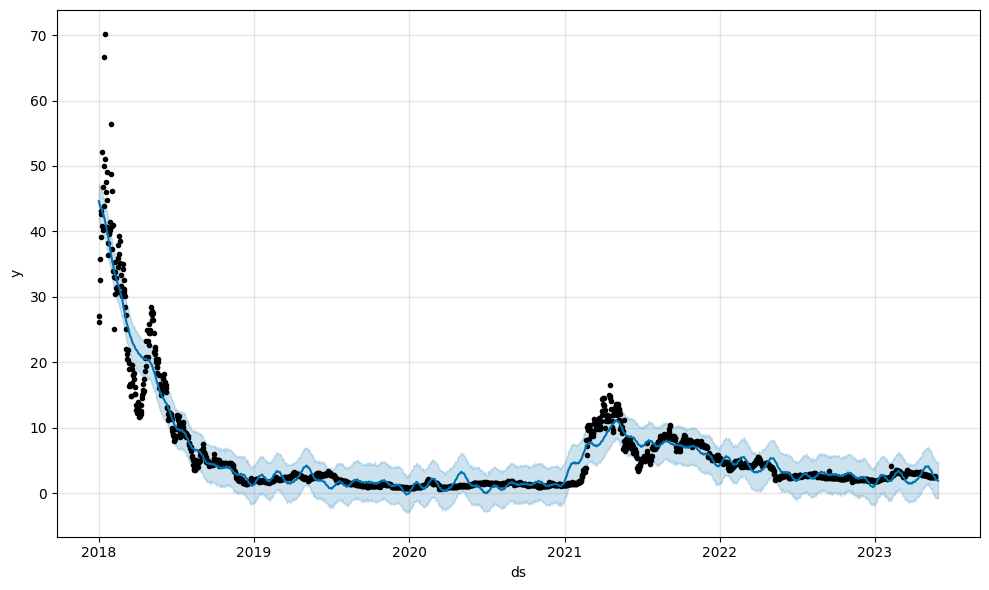

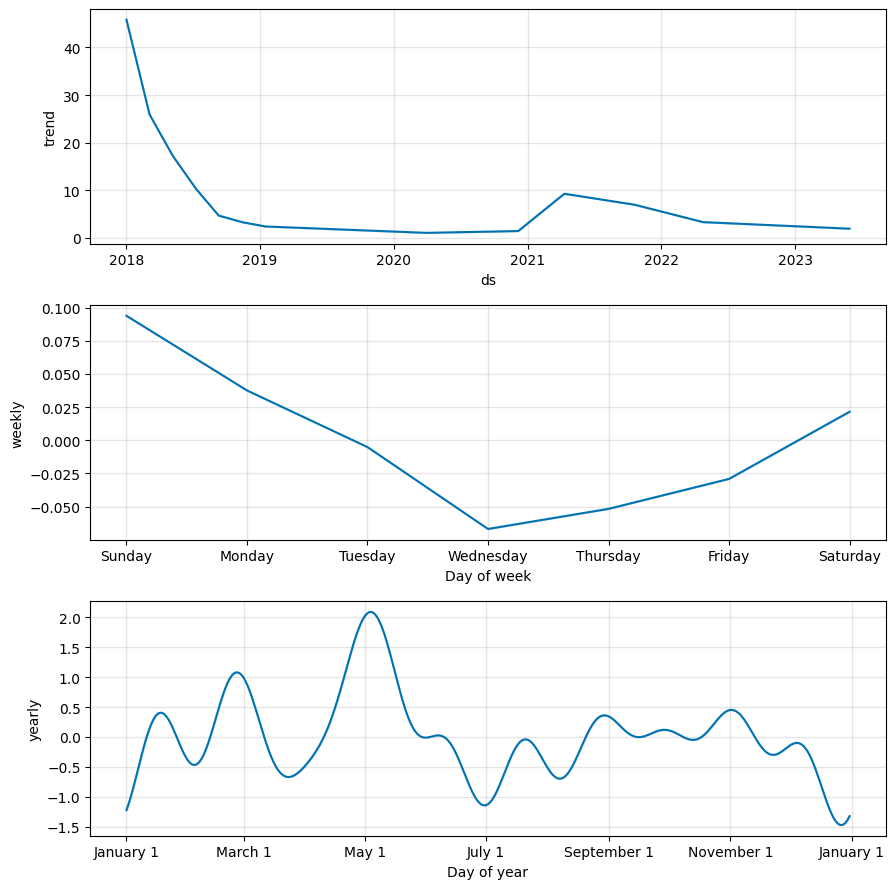

In [64]:
from prophet.plot import plot_plotly, plot_components_plotly

# visulización de las predicciones
fig1 = model.plot(forecast)

# Visualización de los componentes del modelo
fig2 = model.plot_components(forecast)


fig1.show()
fig2.show()

Gráfico de las predicciones:
Este gráfico muestra los datos históricos junto con las predicciones realizadas por el modelo. La línea azul representa los datos observados en el conjunto de entrenamiento, mientras que la línea negra muestra las predicciones realizadas por el modelo. El área sombreada en azul claro representa el intervalo de confianza al 95% de las predicciones.
El gráfico también muestra algunos puntos especiales:

Los círculos negros representan los datos observados en el conjunto de prueba (datos futuros no conocidos por el modelo).
El círculo azul oscuro representa el último dato conocido en el conjunto de entrenamiento.
El círculo verde muestra la fecha de corte entre los conjuntos de entrenamiento y prueba.
Este gráfico te permite evaluar visualmente qué tan bien se ajustan las predicciones del modelo a los datos observados.

Gráfico de los componentes del modelo:
Este gráfico descompone la serie temporal en sus componentes principales: tendencia, estacionalidad y efectos de días festivos. El gráfico muestra tres subgráficos:
El primer subgráfico muestra la tendencia, que es una estimación de la dirección general en la que se mueve la serie temporal a largo plazo.
El segundo subgráfico muestra la estacionalidad, que representa los patrones recurrentes o estacionales en los datos.
El tercer subgráfico muestra los efectos de los días festivos, que capturan las desviaciones específicas relacionadas con días festivos u otras ocasiones especiales.

In [65]:
test_gasn

,Date,Close
1969,2023-05-24,2.659774
1970,2023-05-25,2.610458
1971,2023-05-26,2.545363
1972,2023-05-27,2.505847
1973,2023-05-28,2.587448
1974,2023-05-29,2.688613
1975,2023-05-30,2.700953


In [71]:
# Obtener los valores reales del conjunto de prueba
test_values = test_gasn['Close'].values

# Obtener las predicciones de Prophet
predicted_values = forecast['yhat'].values[-len(test_values):]

# Crear un DataFrame con las dos columnas
df_comparison = pd.DataFrame({'Predicciones': predicted_values, 'Valores Reales': test_values})

df_comparison

,Predicciones,Valores Reales
0,2.168414,2.659774
1,2.107360,2.610458
2,2.065215,2.545363
3,2.062565,2.505847
4,2.092868,2.587448
5,2.005017,2.688613
6,1.940337,2.700953


Evaluar el modelo

In [69]:
# Calcular el MAE
mae = mean_absolute_error(test_values, predicted_values)

# Calcular el MSE
mse = mean_squared_error(test_values, predicted_values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.5509543624691491
MSE: 0.3160047618201488
RMSE: 0.5621430083352


MAE (Mean Absolute Error): Es el error absoluto promedio entre las predicciones y los valores reales. Representa la diferencia promedio entre las predicciones y los valores reales, sin tener en cuenta la dirección de la diferencia. Cuanto menor sea el valor del MAE, mejor será el ajuste del modelo.

MSE (Mean Squared Error): Es el error cuadrático promedio entre las predicciones y los valores reales. Calcula la diferencia cuadrática promedio entre las predicciones y los valores reales, lo que da más peso a las diferencias más grandes. Cuanto menor sea el valor del MSE, mejor será el ajuste del modelo.

RMSE (Root Mean Squared Error): Es la raíz cuadrada del MSE y representa el error promedio entre las predicciones y los valores reales en la misma escala que los datos originales. El RMSE se utiliza comúnmente para interpretar el error de predicción en la misma unidad que los datos originales. Cuanto menor sea el valor del RMSE, mejor será el ajuste del modelo.

En resumen, estos resultados indican que el modelo de Prophet tiene un error promedio absoluto (MAE) de 0.5509, un error cuadrático promedio (MSE) de 0.3160 y un error cuadrático promedio raíz (RMSE) de 0.5621. Cuanto más cercanos a cero sean estos valores, mejor será el rendimiento del modelo en la predicción de los valores reales.